In [1]:
%%time
import dask_gateway
import dask
# Create a connection to dask-gateway.
gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")

# Inspect and change the options if required before creating your cluster.
options = gw.cluster_options()
options.worker_cores = 1 #keeping this at 1 and allowing 15 worker processes seems to run faster than the other way around
options.scheduler_cores = 1 #we need at least one core for the scheduler
#specify which conda env to use, this must match the versions of python and dask (and a few other libraries) used on the notebook service
options.worker_setup='source /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/bin/activate /gws/smf/j04/canari/dask-env'

# Create a dask cluster, or, if one already exists, connect to it.
# This stage creates the scheduler job in SLURM, so may take some time.
# While your job queues.
clusters = gw.list_clusters()
if not clusters:
    cluster = gw.new_cluster(options, shutdown_on_close=False)
else:
    cluster = gw.connect(clusters[0].name)

# Create at least one worker, and allow your cluster to scale to 15.
# The max JASMIN allows is 16, but one of these is used as the scheduler.
cluster.adapt(minimum=1, maximum=15)

# Get a dask client.
client = cluster.get_client()

CPU times: user 1.53 s, sys: 752 ms, total: 2.28 s
Wall time: 26 s


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/home/users/eboland/.conda/envs/canari-dask-mine/lib/python3.10/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/home/users/eboland/.conda/envs/canari-dask-mine/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1007)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/users/eboland/.conda/envs/canari-dask-mine/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/users/eboland/.conda/envs/canari-dask-mine/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "/home/users/eboland/.conda/envs/canari-das

In [27]:
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/"

## CANARI Large Ensemble Beaufort Gyre Freshwater Content

Calculated to match Proshutinsky et al. (2009) https://doi.org/10.1029/2008JC005104

"The FWC is calculated using optimal interpolation on a 50-km square grid between 70˚N and 80˚N, and 130˚W - 170˚W, and where water depths exceed 300 m." "Relative to 34.8"

In [4]:
mesh_mask=xr.open_dataset('/gws/nopw/j04/canari/shared/large-ensemble/ocean/mesh_mask.nc')
mesh_mask=mesh_mask.set_coords(['nav_lon','nav_lat','nav_lev'])
bdepth=mesh_mask.nav_lev.sel(z=mesh_mask.mbathy)

In [5]:
hmask=((mesh_mask.nav_lon>-170)&(mesh_mask.nav_lon<-130)&(mesh_mask.nav_lat>70)&(mesh_mask.nav_lat<80))
bgmask=hmask&(bdepth>300).squeeze()

In [6]:
areacello=xr.open_dataset('/gws/nopw/j04/canari/shared/large-ensemble/ocean/areacello.nc')

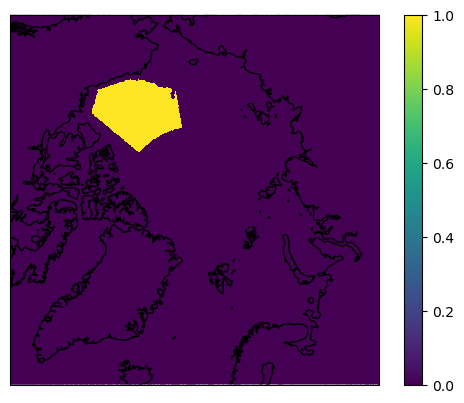

In [22]:
proj=ccrs.NorthPolarStereo()
ax=plt.subplot(projection=proj)
bgmask.plot(x='nav_lon',y='nav_lat',ax=ax,transform= ccrs.PlateCarree())
#ax.scatter(all_data.longitude,all_data.latitude,transform= ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180,180,65,90],ccrs.PlateCarree())

In [39]:
sref=34.8
scenyears={'HIST2':range(2002,2015),'SSP370':range(2015,2100)}
for scen in ['HIST2','SSP370']:
    ensembles=glob.glob(f"{data_path}/{scen}/[0-9]*")
    for ensemble in ensembles:
        if (scen == 'HIST2') & (ensemble[-2:]=='21'):
            continue
        else:
            ensnum=ensemble.split('/')[-1]
            fout=f'../data/BGyre_FWC_{ensnum}_{scen[:-1].lower()}.nc'
            if os.path.isfile(fout):
                print(f'Found file for {scen} {ensnum}, skipping')
                continue
            else:
                print(f'Calculating {scen} {ensnum}')
                FWC_ensemble=[]
                for year in scenyears[scen]:
                    salinity_file=glob.glob(f"{ensemble}/OCN/yearly/{year}/*_mon__grid_T_vosaline.nc")
                    sal=xr.open_dataset(salinity_file[0])
                    foo=sal.vosaline.where(bgmask,drop=True)
                    FWC=((sref-foo)/sref)*mesh_mask.e3t_1d.swap_dims({'z':'deptht'}).squeeze()
                    FWC_total=(FWC.sum('deptht')*areacello.areacello).sum(['y','x'])
                    FWC_ds=xr.Dataset(data_vars={'FWC':FWC,'FWC_total':FWC_total})
                    FWC_ensemble.append(FWC_ds)
                FWC_ensemble=xr.concat(FWC_ensemble,'time_counter').assign_coords({'ens':ensnum,'scen':scen})
                FWC_ensemble.to_netcdf(fout)

Found file for HIST2 1, skipping
Found file for HIST2 10, skipping
Found file for HIST2 11, skipping
Found file for HIST2 12, skipping
Found file for HIST2 13, skipping
Found file for HIST2 14, skipping
Found file for HIST2 15, skipping
Found file for HIST2 16, skipping
Found file for HIST2 17, skipping
Found file for HIST2 18, skipping
Found file for HIST2 19, skipping
Found file for HIST2 2, skipping
Found file for HIST2 20, skipping
Found file for HIST2 22, skipping
Found file for HIST2 23, skipping
Found file for HIST2 24, skipping
Found file for HIST2 25, skipping
Found file for HIST2 26, skipping
Found file for HIST2 27, skipping
Found file for HIST2 28, skipping
Found file for HIST2 29, skipping
Found file for HIST2 3, skipping
Found file for HIST2 30, skipping
Found file for HIST2 31, skipping
Found file for HIST2 32, skipping
Found file for HIST2 33, skipping
Found file for HIST2 34, skipping
Found file for HIST2 35, skipping
Found file for HIST2 36, skipping
Found file for HI

## Observation based Beaufort Gyre FWC
From https://www2.whoi.edu/site/beaufortgyre/data/freshwater-content-gridded-data/ see Proshutinsky et al. (2009) https://doi.org/10.1029/2008JC005104

"The FWC is calculated using optimal interpolation on a 50-km square grid between 70˚N and 80˚N, and 130˚W - 170˚W, and where water depths exceed 300 m." "Relative to 34.8"

In [44]:
BGFWC=xr.open_dataset('../data/BGFWC_OI_2023.nc')

In [45]:
# According to Proshutinsky et al. (2009), on a 50km grid. This matches errors shown on above website
BGFWC['error_total']=(BGFWC.error*50e3*50e3).sum('grid_point')/1e12

In [41]:
BGFWC_CANARI=xr.open_mfdataset('../data/BGyre_FWC_*hist.nc',concat_dim='ens',combine='nested')

In [114]:
BGFWC_CANARI['ens']=BGFWC_CANARI['ens'].astype('int')

In [110]:
BGFWC_CANARI_ssp=xr.open_mfdataset('../data/BGyre_FWC_*ssp37.nc',concat_dim='ens',combine='nested')

/home/users/eboland/.conda/envs/canari-dask-mine/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [111]:
BGFWC_CANARI_ssp['ens']=[int(str(BGFWC_CANARI_ssp.ens[i].values).split('/')[-1]) for i in range(0,7)]

In [115]:
BGFWC_CANARI

<xarray.Dataset>
Dimensions:       (time_counter: 156, deptht: 75, y: 87, x: 120, ens: 39)
Coordinates:
  * time_counter  (time_counter) object 2002-01-16 00:00:00 ... 2014-12-16 00...
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * y             (y) float64 1.077e+03 1.078e+03 ... 1.162e+03 1.163e+03
  * x             (x) float64 420.0 421.0 422.0 423.0 ... 537.0 538.0 539.0
    nav_lat       (y, x) float32 dask.array<chunksize=(87, 120), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(87, 120), meta=np.ndarray>
  * ens           (ens) int64 10 11 12 13 14 15 16 17 18 ... 39 3 40 4 5 6 7 8 9
Data variables:
    FWC           (ens, time_counter, deptht, y, x) float64 dask.array<chunksize=(1, 156, 75, 87, 120), meta=np.ndarray>
    FWC_total     (ens, time_counter) float64 dask.array<chunksize=(1, 156), meta=np.ndarray>

In [116]:
BGFWC_all=xr.concat([BGFWC_CANARI,BGFWC_CANARI_ssp],'time_counter')

/home/users/eboland/.conda/envs/canari-dask-mine/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [117]:
BGFWC_CANARI_yearly=BGFWC_all.groupby(BGFWC_all.time_counter.dt.year).mean()
BGFWC_CANARI_yearly

<xarray.Dataset>
Dimensions:    (deptht: 75, y: 87, x: 120, ens: 39, year: 98)
Coordinates:
  * deptht     (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * y          (y) float64 1.077e+03 1.078e+03 1.079e+03 ... 1.162e+03 1.163e+03
  * x          (x) float64 420.0 421.0 422.0 423.0 ... 536.0 537.0 538.0 539.0
  * ens        (ens) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
    nav_lat    (y, x) float32 74.2 74.18 74.15 74.13 ... 73.88 73.79 73.71 73.62
    nav_lon    (y, x) float32 -177.2 -176.8 -176.4 ... -118.7 -118.6 -118.5
  * year       (year) int64 2002 2003 2004 2005 2006 ... 2096 2097 2098 2099
Data variables:
    FWC        (year, ens, deptht, y, x) float64 dask.array<chunksize=(1, 1, 75, 87, 120), meta=np.ndarray>
    FWC_total  (year, ens) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

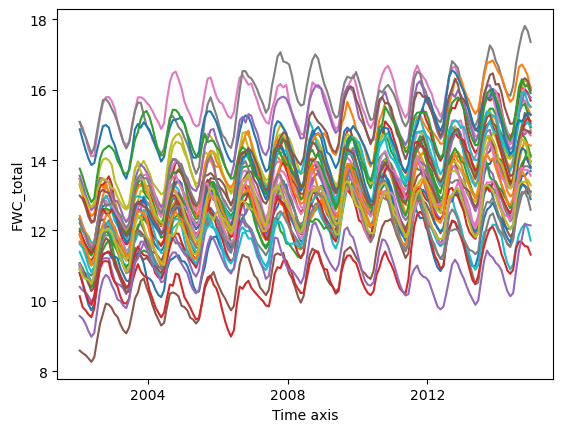

In [119]:
pp=(BGFWC_CANARI.FWC_total/1e12).plot(hue='ens',add_legend=False)

(2002.0, 2024.0)

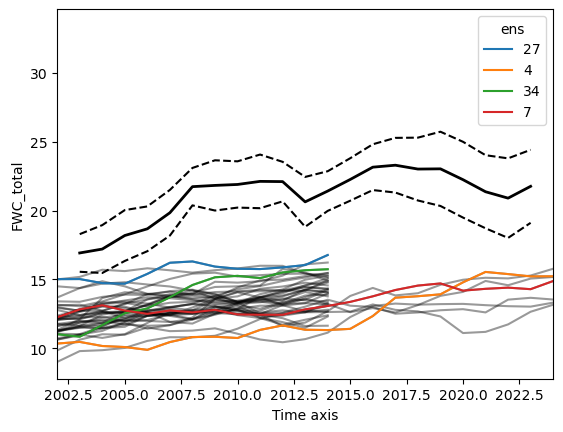

In [143]:
p1=BGFWC.fwc_total.plot(color='k',lw=2)
(BGFWC.fwc_total+BGFWC['error_total']).plot(ls='--',color='k')
(BGFWC.fwc_total-BGFWC['error_total']).plot(ls='--',color='k')
pp=(BGFWC_CANARI_yearly.FWC_total/1e12).plot(hue='ens',add_legend=False,color='k',alpha=0.4)
pp2=(BGFWC_CANARI_yearly.FWC_total.sel(ens=[imax,imin,ivarmax,ivarmin])/1e12).plot(hue='ens')
plt.xlim([2002,2024])

In [130]:
imax=BGFWC_CANARI.FWC_total.mean('time_counter').idxmax().load()
imin=BGFWC_CANARI.FWC_total.mean('time_counter').idxmin().load()

In [131]:
print(imax,imin)

<xarray.DataArray 'ens' ()>
array(27.) <xarray.DataArray 'ens' ()>
array(4.)


In [136]:
ivarmax=BGFWC_CANARI.FWC_total.var('time_counter').idxmax().load()
ivarmin=BGFWC_CANARI.FWC_total.var('time_counter').idxmin().load()

In [137]:
print(ivarmax,ivarmin)

<xarray.DataArray 'ens' ()>
array(34.) <xarray.DataArray 'ens' ()>
array(7.)


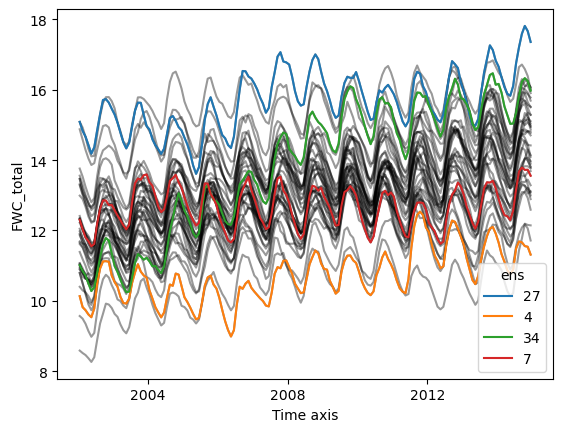

In [139]:
pp=(BGFWC_CANARI.FWC_total/1e12).plot(hue='ens',add_legend=False,color='k',alpha=0.4)
pp2=(BGFWC_CANARI.FWC_total.sel(ens=[imax,imin,ivarmax,ivarmin])/1e12).plot(hue='ens')

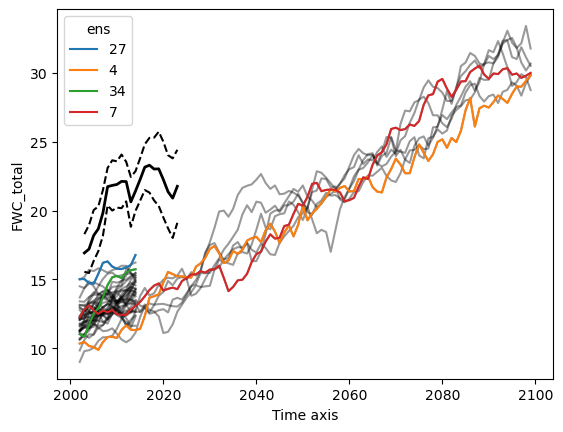

In [140]:
p1=BGFWC.fwc_total.plot(color='k',lw=2)
(BGFWC.fwc_total+BGFWC['error_total']).plot(ls='--',color='k')
(BGFWC.fwc_total-BGFWC['error_total']).plot(ls='--',color='k')
pp=(BGFWC_CANARI_yearly.FWC_total/1e12).plot(hue='ens',add_legend=False,color='k',alpha=0.4)
pp2=(BGFWC_CANARI_yearly.FWC_total.sel(ens=[imax,imin,ivarmax,ivarmin])/1e12).plot(hue='ens')